## AI Text Summarization

### Data Description
The **CNN/Daily Mail dataset** is a popular benchmark for text summarization. It consists of news articles from CNN and the Daily Mail newspapers paired with human-written summaries (called highlights). Researchers commonly use this dataset to train and evaluate summarization models, as it provides a large collection of real-world articles and reference summaries. In total, the dataset has over 300,000 article-summary pairs (about 287k for training, 13k for validation, 11k for test). Each article is a news story (multiple paragraphs long), and the corresponding highlights are a few sentences giving a brief summary of the article’s main points.

For this project, the dataset is provided in three CSV files (train.csv, validation.csv, test.csv). We downloaded the data from kaggle using the kaggle API and stored it under a data/ folder. Each file has three columns: id, article, and highlights. The article is the full news text, and highlights is the summary.

In [21]:
# Importing the necessary libraries
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from collections import Counter
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Import PEFT to use LoRA
from peft import LoraConfig, get_peft_model, TaskType

import pickle

# Apply tqdm to all .apply() functions by using progress_apply
tqdm.pandas()

# Initialize tokenizers for T5 and BART
tokenizer_t5 = AutoTokenizer.from_pretrained('t5-small')
tokenizer_bart = AutoTokenizer.from_pretrained('facebook/bart-large-cnn')


# Use GPU if available
# Check for NVIDIA GPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA (NVIDIA GPU)
    print("Using NVIDIA GPU (CUDA)")
# Check for Mac Silicon GPU (MPS)
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal Performance Shaders (Mac Silicon GPU)
    print("Using Mac GPU (MPS)")
# Default to CPU if no GPU is available
else:
    device = torch.device("cpu")
    print("Using CPU")

Using Mac GPU (MPS)


In [22]:
# Load the dataset
train_df = pd.read_csv('../data/cnn_dailymail/train.csv')
val_df   = pd.read_csv('../data/cnn_dailymail/validation.csv')
test_df  = pd.read_csv('../data/cnn_dailymail/test.csv')

# Select 2% of the DataFrame and reset the index without inplace=True
train_df = train_df.sample(frac=0.05, random_state=42).reset_index(drop=True)
val_df   = val_df.sample(frac=0.05, random_state=42).reset_index(drop=True)
test_df  = test_df.sample(frac=0.05, random_state=42).reset_index(drop=True)

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))
print("Testing samples:", len(test_df))
train_df.head(5)

Training samples: 14356
Validation samples: 668
Testing samples: 574


,id,article,highlights
0,ed0fed726929c1eeabe6c390e47128dbb7d7a055,By . Mia De Graaf . Britons flocked to beaches...,People enjoyed temperatures of 17C at Brighton...
1,023cd84001b33aed4ff0f3f5ecb0fdd2151cf543,A couple who weighed a combined 32st were sham...,Couple started piling on pounds after the birt...
2,6a70a0d8d3ed365fe1df6d35f1587a8b9b298618,Video footage shows the heart stopping moment ...,A 17-year-old boy suffering lacerations to his...
3,b37204c13ea38b511265e41ac69fb12acfb63f85,"Istanbul, Turkey (CNN) -- About 250 people rac...",Syrians citizens hightail it to Turkey .\nMost...
4,c24e5805afd5145bc48410e876db91d44a06be5e,By . Daily Mail Reporter . PUBLISHED: . 12:53 ...,The Xue Long had provided the helicopter that ...


In [23]:
# Show a sample article and its highlights (summary)
sample = train_df.iloc[96]
print("Article ID:", sample['id'])
print("Article text (truncated):", sample['article'][:300], "...")
print("\nReference Summary:", sample['highlights'])

Article ID: 31988bc087e6281d089b5227482720c92e600920
Article text (truncated): By . Victoria Woollaston . PUBLISHED: . 09:29 EST, 24 October 2013 . | . UPDATED: . 09:37 EST, 24 October 2013 . The days of waiting for eBay sellers to post your purchases, and making sure you're home when they arrive, are numbered. The auction site has bought London-based courier service Shutl tha ...

Reference Summary: Ebay has bought London-based superfast delivery service Shutl .
Shutl can deliver items bought and sold in the same region within an hour .
It has couriers that can collect and deliver in most major UK cities .
Firm's record time is 14 minutes but buyers can select different days too .
It already has deals with high-street stores Argos, Maplin and Warehouse .


In the above example, the article (truncated for display) is a CNN news story, and the highlights consist of several key points from the story. The highlights are written in a few sentences in new lines. This illustrates the typical input-output pair for our summarization task: input is a long news article, output is a short summary capturing the article’s main facts.

### Data Cleaning

Real-world text data often requires cleaning before modeling. We will perform the following cleaning steps:
- Handling Missing Values: First, check if any articles or highlights are missing (null). If so, those rows would be removed because a summarization pair with a missing text or summary is not usable.
- Outlier Detection: Check for any extremely short or long articles/summaries that might be anomalies (for example, an article with only one sentence, or a summary that is uncharacteristically long). We might handle these on a case-by-case basis (perhaps exclude if they seem like data errors).
- Text Preprocessing: Clean the text by standardizing case and removing unwanted characters:
    - Convert text to lowercase (for models that are not case-sensitive, like a custom LSTM, to reduce vocabulary size).
    - Remove or normalize special characters, digits, or extraneous symbols that don’t contribute meaning. For instance, the CNN articles often start with location strings like “(CNN) – “, which we can remove because they are not useful for summarization. We also remove any lingering HTML entities or odd punctuation.
    - Fix spacing issues (remove extra whitespaces or newline characters within the article text). In many cases, the highlights in this dataset are separated by newline characters in the raw data; we might want to join them into a single summary string (the CSV may have already done this by putting all bullet points into one text).

In [24]:
# Missing value check
print("Missing in articles:", train_df['article'].isnull().sum())
print("Missing in highlights:", train_df['highlights'].isnull().sum())

Missing in articles: 0
Missing in highlights: 0


In [25]:
# Function to remove prefixes from the article text
def clean_prefix(text):
    # Remove news source prefixes (with or without location)
    # This pattern matches an optional location (letters, spaces, commas)
    # followed by a parenthesized news source.
    text = re.sub(r'^(?:[\w\s,]+)?\s*\(\s*[A-Za-z. ]+\s*\)\s*', '', text)
    
    # Remove full publication info starting with "By . Associated Press" followed by publication details.
    # The non-greedy ".*?" will catch everything until the final period of the prefix.
    text = re.sub(r'^By\s*\.\s*Associated\s+Press\s*\..*?UPDATED:\s*\..*?\.\s*', '', text, flags=re.DOTALL)
    
    # Remove publication info starting directly with "PUBLISHED:"
    text = re.sub(r'^PUBLISHED:\s*\..*?UPDATED:\s*\..*?\.\s*', '', text, flags=re.DOTALL)

    # Normalize whitespace
    text = ' '.join(text.split())
    
    return text

# Apply cleaning to articles
train_df['article'] = train_df['article'].progress_apply(lambda x: clean_prefix(str(x)))
val_df['article'] = val_df['article'].progress_apply(lambda x: clean_prefix(str(x)))
test_df['article'] = test_df['article'].progress_apply(lambda x: clean_prefix(str(x)))

100%|██████████| 574/574 [00:00<00:00, 25782.63it/s]


In [26]:
# Verify the removal of prefixes
sample = train_df.iloc[96]
print("Article text (truncated):", sample['article'][:300], "...")

Article text (truncated): By . Victoria Woollaston . PUBLISHED: . 09:29 EST, 24 October 2013 . | . UPDATED: . 09:37 EST, 24 October 2013 . The days of waiting for eBay sellers to post your purchases, and making sure you're home when they arrive, are numbered. The auction site has bought London-based courier service Shutl tha ...


In [27]:
# Function to clean text
def clean_text(text):
    # Remove HTML tags (anything between < and >)
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove URLs (matches http://, https://, or www.)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove newline characters (replace them with a space)
    text = re.sub(r'\n+', ' ', text)
    
    # Remove extra spaces: replace any sequence of whitespace with a single space and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning to articles
train_df['article'] = train_df['article'].progress_apply(lambda x: clean_text(str(x)))
val_df['article'] = val_df['article'].progress_apply(lambda x: clean_text(str(x)))
test_df['article'] = test_df['article'].progress_apply(lambda x: clean_text(str(x)))

100%|██████████| 574/574 [00:00<00:00, 5953.97it/s]


### Data Exploration
Before building models, it’s important to explore the dataset to understand its characteristics. We will look at statistics like the length of articles vs. summaries, and visualize their distributions. This will inform decisions like truncating long articles for modeling or setting max sequence lengths.

100%|██████████| 14356/14356 [00:00<00:00, 433951.89it/s]


Avg article length (words): 697.5170660351073
Avg summary length (words): 51.80614377263862
Max article length: 1955
Max summary length: 439
Min article length: 20
Min summary length: 6


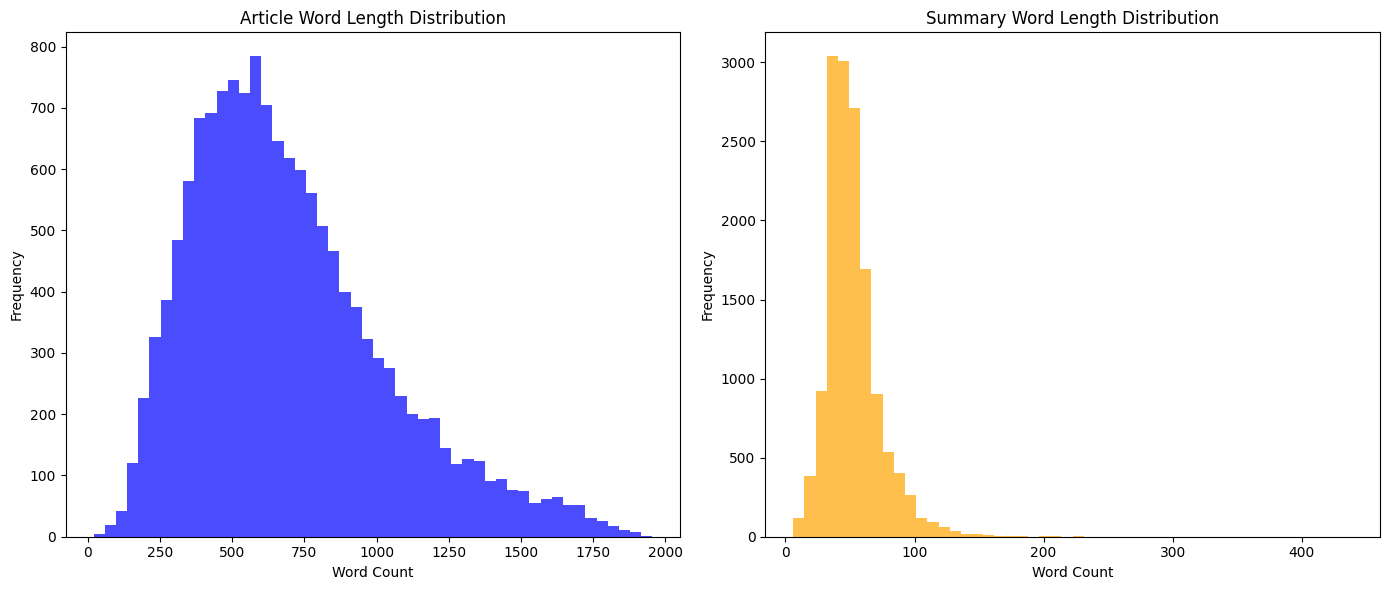

In [28]:
# Compute length (in words) of each article and summary
train_df['article_len'] = train_df['article'].progress_apply(lambda x: len(x.split()))
train_df['summary_len'] = train_df['highlights'].progress_apply(lambda x: len(x.split()))

print("Avg article length (words):", train_df['article_len'].mean())
print("Avg summary length (words):", train_df['summary_len'].mean())
print("Max article length:", train_df['article_len'].max())
print("Max summary length:", train_df['summary_len'].max())
print("Min article length:", train_df['article_len'].min())
print("Min summary length:", train_df['summary_len'].min())


# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

bins = 50  # Number of bins for the histograms; adjust as needed

# Plot histogram for article word lengths
ax1.hist(train_df['article_len'], bins=bins, alpha=0.7, color='blue')
ax1.set_title('Article Word Length Distribution')
ax1.set_xlabel('Word Count')
ax1.set_ylabel('Frequency')

# Plot histogram for summary word lengths
ax2.hist(train_df['summary_len'], bins=bins, alpha=0.7, color='orange')
ax2.set_title('Summary Word Length Distribution')
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Frequency')

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

From the histograms above, we observe that:
- Article lengths vary greatly. Many articles cluster in the within-1000 word range, but there is a tail of longer articles approaching ~1000-1500 words or more. This variance implies our models must handle quite long inputs (and we may consider truncating very long articles due to memory limits). But, there are some articles with extremely short length. These are articles with basically missing content, and we will be removing them from our training set.
- Summary lengths are relatively tight: most summaries are between 40 and 100 words, with a peak around 50 words. Nearly all summaries are just a few sentences. But, there are some summaries that are extremely long. We want out model to generate relatively short summaries so that we can set a reasonable maximum length for generated summaries (e.g., 150 tokens) when configuring our models.

We can also explore if there’s any correlation between article length and summary length:

In [29]:
# Filter the DataFrame to keep only rows where article_len is >= 40
train_df = train_df[train_df['article_len'] >= 40].copy()

# Optionally, reset the index if needed
train_df.reset_index(drop=True, inplace=True)

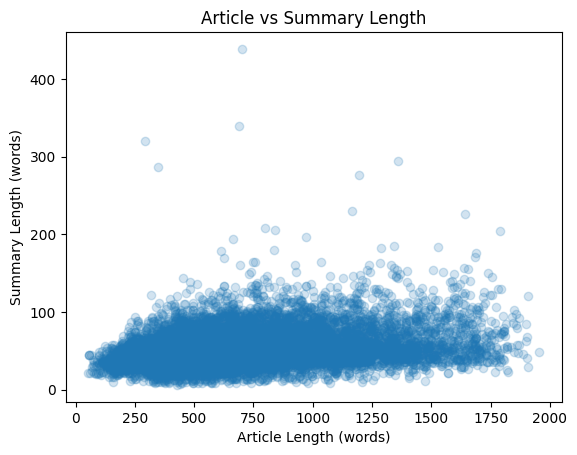

In [30]:
# Scatter plot of article length vs summary length
plt.scatter(train_df['article_len'], train_df['summary_len'], alpha=0.2)
plt.xlabel("Article Length (words)")
plt.ylabel("Summary Length (words)")
plt.title("Article vs Summary Length")
plt.show()

We see almost no correlation. The editors likely write ~3-4 highlight bullet points regardless of article length (though extremely long articles might have slightly longer summaries). Generally, summary length doesn’t increase proportionally with article length in this dataset.

In [31]:
word_counts_article = Counter(" ".join(train_df['article']).split())
word_counts_summary = Counter(" ".join(train_df['highlights']).split())
print("Most common words in articles:", word_counts_article.most_common(10))
print("Most common words in summaries:", word_counts_summary.most_common(10))

Most common words in articles: [('the', 494085), ('to', 269839), ('of', 228885), ('a', 227314), ('and', 225979), ('in', 192691), ('.', 154454), ('was', 95859), ('for', 89757), ('that', 87299)]
Most common words in summaries: [('.', 50919), ('the', 22332), ('to', 18136), ('in', 16178), ('of', 14288), ('a', 12989), ('and', 12932), ('for', 7192), ('was', 7083), ('on', 6758)]


In [32]:
# Drop columns used for exploration
train_df.drop(['article_len', 'summary_len'], axis=1, inplace=True)

### Feature Engineering

Feature engineering for text summarization largely revolves around text tokenization and preparation. Unlike structured datasets, we don’t have numerical features to scale or one-hot encode; the “features” are the words (or subwords) in the text. We will prepare the data differently for our three modeling approaches:
1. **Custom LSTM with Attention:** We will perform word-level tokenization and build a vocabulary dictionary for the words.
2. **T5-small fine-tuning:** We will use Hugging Face’s tokenizer for T5 which uses a text-to-text format with subword tokens. We’ll prepend a special prefix “summarize:” to each article (as T5 was trained to expect task-specific prefixes ￼).
3. **BART-large-cnn fine-tuning:** We will use BART’s tokenizer (which is also subword-based). BART doesn’t require a prefix for summarization; we feed the article text as input.

#### Tokenization and Vocabulary for LSTM

For the LSTM model, we use a vocabulary of words:
- First, we tokenize the text by splitting on whitespace (after our cleaning, punctuation like periods are attached to words, but we might treat them as separate tokens or keep them – to keep it simple, we will keep punctuation attached, except we removed weird symbols already).
- Build a vocabulary of the most frequent words. A typical choice is to limit vocabulary size (e.g., the top 50,000 words) to handle memory and ignore extremely rare words. Words not in the vocabulary will be treated as UNK (unknown).
- Add special tokens for PAD (padding), SOS (start-of-summary), and EOS (end-of-sequence) which our model will use. PAD is used to pad sequences to the same length in a batch; SOS and EOS will wrap target sequences so the model knows where the summary starts and ends.

In [33]:
# Tokenize all training articles and summaries
all_article_words = []
all_summary_words = []
for text in train_df['article']:
    all_article_words.extend(text.lower().split())  # using lowercased text for LSTM vocab
for text in train_df['highlights']:
    all_summary_words.extend(text.lower().split())

# Count frequencies
word_freq = Counter(all_article_words + all_summary_words)
print("Total unique tokens:", len(word_freq))

# Define a vocab size limit (to ignore rare words)
vocab_size = 10000
most_common = word_freq.most_common(vocab_size-4)  # minus 4 to leave space for special tokens
vocab_words = [w for w, _ in most_common]

# Create word to index mapping
PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN = "<PAD>", "<SOS>", "<EOS>", "<UNK>"
vocab = {PAD_TOKEN: 0, SOS_TOKEN: 1, EOS_TOKEN: 2, UNK_TOKEN: 3}
for i, word in enumerate(vocab_words, start=4):
    vocab[word] = i

print("Vocab size (including special tokens):", len(vocab))

# Save the vocab dictionary to a file named 'vocab.pkl'
with open('../saved_models/lstm/vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

Total unique tokens: 336282
Vocab size (including special tokens): 10000


Next, we convert each article and summary in our dataset to a sequence of integers (token indices) using this vocabulary. We will also pad or truncate sequences to a fixed length for batching:
- For articles, we might choose a max length of 400 for the LSTM. This is a trade-off: covering as much content as possible vs. not making sequences too long for the model. In many research works, 400 tokens is a common cutoff for CNN/DM summarization with RNNs (since including the entire article might not improve summary quality beyond a point, and 400 covers most content).
- For summaries (targets), a max length of 100 tokens is sufficient as we saw in exploration that summaries are usually < 100 words. We will pad them to a fixed length as well for convenience (and use EOS to mark actual end).

In [14]:
MAX_ARTICLE_LEN = 400   # chosen cutoff for LSTM encoder
MAX_SUMMARY_LEN = 100   # chosen max for summary (including SOS/EOS)

def text_to_sequence(text, max_len, add_eos=False):
    words = text.lower().split()
    if add_eos:
        words = words + [EOS_TOKEN]  # append EOS
    # Truncate if too long
    if len(words) > max_len:
        words = words[:max_len]
        if add_eos and words[-1] != EOS_TOKEN:
            words[-1] = EOS_TOKEN  # ensure it ends with EOS if truncated
    # Convert to ids, use UNK if not in vocab
    seq = [vocab.get(w, vocab[UNK_TOKEN]) for w in words]
    # Pad sequence to max_len with PAD token
    if len(seq) < max_len:
        seq += [vocab[PAD_TOKEN]] * (max_len - len(seq))
    return seq

# Convert and pad all sets
train_articles_seq = np.array([text_to_sequence(txt, MAX_ARTICLE_LEN, add_eos=False) 
                               for txt in train_df['article']])
train_summaries_seq = np.array([text_to_sequence(SOS_TOKEN + " " + txt, MAX_SUMMARY_LEN, add_eos=True) 
                                for txt in train_df['highlights']])

In the code above, for summaries we did SOS_TOKEN + " " + txt and add_eos=True. This means each summary sequence starts with SOS and ends with EOS, with padding after EOS if needed. The model will be trained to output everything up to but not including EOS token. For articles, we did not add any special token (the encoder will process the raw article words, possibly truncated/padded).

#### Tokenization for T5 and BART
For the transformer models (T5 and BART), we will leverage Hugging Face’s transformers library, which provides ready-made subword tokenizers and model architectures. These tokenizers handle details like splitting words into subword pieces (especially useful for rare words or proper nouns) and adding special tokens that the models expect.

**T5 Tokenization:** T5 is a text-to-text model, and by convention, we prepend "summarize: " to the input text to indicate a summarization task ￼. We’ll use the T5Tokenizer (or AutoTokenizer) which will:
- Encode the input article (with the prefix) into a sequence of token IDs.
- Encode the target summary into token IDs.

T5 uses its own special tokens like <pad> and <eos> internally (the tokenizer will handle those; in T5, the end-of-sequence is typically the <\sep> token or just the end-of-sentence token). We will specify a maximum length for inputs (e.g., 512 tokens for T5-small to save memory) and outputs (e.g., 128 tokens for summary). The tokenizer can automatically truncate longer texts and pad shorter ones.

**BART Tokenization:** BART’s tokenizer will similarly encode the article and summary. BART-large can handle up to 1024 tokens in the encoder. We will likely use that as max length (or slightly less if memory is an issue on our hardware). BART uses <s> as start and </s> as end-of-sequence tokens automatically.

We will prepare the data for these models.

In [15]:
# Define tokenization function for T5
def tokenize_for_t5(example):
    article_text = example['article']
    summary_text = example['highlights']
    # Add T5 prefix
    input_text = "summarize: " + article_text
    # Encode article
    inputs = tokenizer_t5(input_text, max_length=512, truncation=True, padding="max_length")
    # Encode summary as target
    labels = tokenizer_t5(summary_text, max_length=128, truncation=True, padding="max_length")
    # Important: replace padding token id in labels with -100 so they are ignored in loss
    labels_ids = labels["input_ids"]
    labels_ids = [(-100 if token_id == tokenizer_t5.pad_token_id else token_id) for token_id in labels_ids]
    return {"input_ids": inputs["input_ids"], "attention_mask": inputs["attention_mask"], "labels": labels_ids}

# Define tokenization function for BART
def tokenize_for_bart(example):
    article_text = example['article']
    summary_text = example['highlights']
    # Encode article (BART's tokenizer will add <s> and </s> tokens as needed)
    inputs = tokenizer_bart(article_text, max_length=1024, truncation=True, padding="max_length")
    # Encode summary
    labels = tokenizer_bart(summary_text, max_length=128, truncation=True, padding="max_length")
    # Mask out padding in labels for loss computation
    labels_ids = labels["input_ids"]
    labels_ids = [(-100 if token_id == tokenizer_bart.pad_token_id else token_id) for token_id in labels_ids]
    return {"input_ids": inputs["input_ids"], "attention_mask": inputs["attention_mask"], "labels": labels_ids}

In [16]:
# Convert your Pandas DataFrames to Hugging Face Datasets.
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Combine into a DatasetDict.
dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

# Verify the dataset structure.
print("Dataset splits:", dataset)
print("Example record from training set:")
print(dataset["train"][0])

Dataset splits: DatasetDict({
    train: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 14355
    })
    validation: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 668
    })
    test: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 574
    })
})
Example record from training set:
{'id': 'ed0fed726929c1eeabe6c390e47128dbb7d7a055', 'article': "By . Mia De Graaf . Britons flocked to beaches across the southern coast yesterday as millions look set to bask in glorious sunshine today. Temperatures soared to 17C in Brighton and Dorset, with people starting their long weekend in deck chairs by the sea. Figures from Asda suggest the unexpected sunshine has also inspired a wave of impromptu barbecues, with sales of sausages and equipment expected to triple those in April. Sun's out: Brighton beach was packed with Britons enjoying the unexpected sunshine to start the long weekend as temperatures hit 17C

In [17]:
# Initialize the T5-small tokenizer.
tokenizer_t5 = AutoTokenizer.from_pretrained("t5-small")

# Apply the tokenization function to all splits in the dataset.
t5_tokenized_datasets = dataset.map(tokenize_for_t5, batched=False)

# Remove the original text columns ('id', 'article', 'highlights')
columns_to_remove = ["id", "article", "highlights"]
t5_tokenized_datasets = t5_tokenized_datasets.remove_columns(columns_to_remove)

# Set the dataset format to PyTorch tensors.
t5_tokenized_datasets.set_format("torch")

# Print an example tokenized record from the training set.
print("Example tokenized record:")
print(t5_tokenized_datasets["train"][0])

Map: 100%|██████████| 574/574 [00:02<00:00, 203.19 examples/s]

Example tokenized record:
{'input_ids': tensor([21603,    10,   938,     3,     5,  2133,     9,   374,     3,  4744,
            9,    89,     3,     5,  7834,  8057,     3,    89, 11863,    12,
         9252,   640,     8,  7518,  4939,  4981,    38,  4040,   320,   356,
           12,  3905,   157,    16, 18020, 18275,   469,     5, 12579,    15,
            7,     3, 14266,    26,    12,  1003,   254,    16, 25080,    11,
         6200,  2244,     6,    28,   151,  1684,    70,   307,  1851,    16,
         3854,  6406,    57,     8,  2805,     5,  7996,     7,    45,   282,
           26,     9,  3130,     8,  7544, 18275,    65,    92,  3555,     3,
            9,  6772,    13,     3, 16260,  1167,    17,    76, 17621,     7,
            6,    28,  1085,    13, 18567,     7,    11,  1277,  1644,    12,
        12063,   273,    16,  1186,     5,  3068,    31,     7,    91,    10,
        25080,  2608,    47,  7614,    28,  7834,  8057,  5889,     8,  7544,
        18275,    12,   

In [18]:
# Initialize the bart-large-cnn tokenizer.
tokenizer_bart = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")

# Apply the tokenization function to all splits in the dataset.
bart_tokenized_datasets = dataset.map(tokenize_for_bart, batched=False)

# Remove the original text columns ('id', 'article', 'highlights')
columns_to_remove = ["id", "article", "highlights"]
bart_tokenized_datasets = bart_tokenized_datasets.remove_columns(columns_to_remove)

# Set the dataset format to PyTorch tensors.
bart_tokenized_datasets.set_format("torch")

# Print an example tokenized record from the training set.
print("Example tokenized record:")
print(bart_tokenized_datasets["train"][0])

Map: 100%|██████████| 574/574 [00:01<00:00, 401.08 examples/s]

Example tokenized record:
{'input_ids': tensor([   0, 2765,  479,  ...,    1,    1,    1]), 'attention_mask': tensor([1, 1, 1,  ..., 0, 0, 0]), 'labels': tensor([    0,  4763,  3776,  3971,     9,   601,   347,    23, 11946,  4105,
           11,   580, 11799,     8,   166,  8307, 15617,    11,   211, 30057,
          479, 50118,  1620,  6106,  1449,    24,    40,  1331,    10,   153,
         2241,   687,  3443,    81,   251,   983,  1135,   363,  3971,  6614,
            7, 10877,   112,   347,   479, 50118,  1708,     5,   205,  1650,
           34,    45,    57,  3776,    30,    70,    25,     5,  1926,  3072,
            8,  3430,    33,   450,  2016,  1895,   479,     2,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -

### Model Building
We will build and train three models for summarization:
1. LSTM with Attention (from scratch in PyTorch) – an encoder-decoder architecture using LSTM layers and a custom attention mechanism.
2. T5-small (60M param transformer) – using a pre-trained model from Hugging Face, fine-tuned on our dataset.
3. BART-large-cnn (406M param transformer) – using a pre-trained BART model fine-tuned on CNN/DailyMail (we will fine-tune it further or at least use it on our data).

#### LSTM with Attention

In [50]:
# Encoder: LSTM
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, enc_hidden_dim):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab[PAD_TOKEN])
        self.lstm = nn.LSTM(embed_dim, enc_hidden_dim, batch_first=True)
    def forward(self, src_sequences):
        # src_sequences: [batch_size, seq_len]
        embedded = self.embedding(src_sequences)            # [batch, seq_len, embed_dim]
        outputs, (hidden, cell) = self.lstm(embedded)       # outputs: [batch, seq_len, enc_hidden_dim]
        # hidden: [1, batch, enc_hidden_dim] (1 layer), cell: [1, batch, enc_hidden_dim]
        return outputs, hidden, cell

# Attention module (additive attention)
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim, attn_dim):
        super(Attention, self).__init__()
        # We create layers to compute alignment scores
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, attn_dim)
        self.v = nn.Linear(attn_dim, 1, bias=False)
    def forward(self, dec_hidden, enc_outputs):
        # dec_hidden: [batch, dec_hidden_dim]
        # enc_outputs: [batch, src_len, enc_hidden_dim]
        batch_size = enc_outputs.size(0)
        src_len = enc_outputs.size(1)
        # Repeat decoder hidden state across all timesteps to concat with encoder outputs
        dec_hidden_exp = dec_hidden.unsqueeze(1).repeat(1, src_len, 1)   # [batch, src_len, dec_hidden_dim]
        # Concatenate decoder hidden and encoder outputs
        concat = torch.cat((enc_outputs, dec_hidden_exp), dim=2)         # [batch, src_len, enc_hidden_dim+dec_hidden_dim]
        # Compute energy scores
        energy = torch.tanh(self.attn(concat))                          # [batch, src_len, attn_dim]
        scores = self.v(energy).squeeze(2)                              # [batch, src_len]
        # Compute attention weights
        attn_weights = torch.softmax(scores, dim=1)                     # [batch, src_len]
        # Weighted sum of encoder outputs
        context = torch.bmm(attn_weights.unsqueeze(1), enc_outputs).squeeze(1)  # [batch, enc_hidden_dim]
        return context, attn_weights

# Decoder: LSTM with attention
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, enc_hidden_dim, dec_hidden_dim, attention):
        super(Decoder, self).__init__()
        self.attention = attention
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab[PAD_TOKEN])
        # LSTM will take concatenated [embedded_word, context] as input features
        self.lstm = nn.LSTM(enc_hidden_dim + embed_dim, dec_hidden_dim, batch_first=True)
        # Output layer: takes [decoder_hidden, context, embedded_input] to predict next token
        self.fc_out = nn.Linear(enc_hidden_dim + dec_hidden_dim + embed_dim, vocab_size)
    def forward(self, input_token, hidden, cell, enc_outputs):
        # input_token: [batch] (indices of current word input to decoder)
        embedded = self.embedding(input_token).unsqueeze(1)         # [batch, 1, embed_dim]
        # Use last hidden state of decoder (hidden is [1,batch,dec_hidden]; use hidden[0] since 1 layer)
        dec_hidden = hidden[-1]  # [batch, dec_hidden_dim]
        # Compute attention to get context vector
        context, attn_weights = self.attention(dec_hidden, enc_outputs)  # context: [batch, enc_hidden_dim]
        context = context.unsqueeze(1)                                   # [batch, 1, enc_hidden_dim]
        # Prepare LSTM input by concatenating context with embedded current word
        lstm_input = torch.cat((embedded, context), dim=2)          # [batch, 1, embed_dim+enc_hidden_dim]
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        # Now output is [batch, 1, dec_hidden_dim]
        output = output.squeeze(1)     # [batch, dec_hidden_dim]
        context = context.squeeze(1)   # [batch, enc_hidden_dim]
        embedded = embedded.squeeze(1) # [batch, embed_dim]
        # Compute final output distribution over vocabulary
        pred_input = torch.cat((output, context, embedded), dim=1)   # [batch, enc_hidden_dim+dec_hidden_dim+embed_dim]
        preds = self.fc_out(pred_input)                             # [batch, vocab_size]
        return preds, hidden, cell, attn_weights

In [51]:
# Set dimensions and instantiate models
vocab_size = len(vocab)
embed_dim = 128
enc_hidden_dim = 256
dec_hidden_dim = 256
attn_dim = 256

encoder = Encoder(vocab_size, embed_dim, enc_hidden_dim)
attn = Attention(enc_hidden_dim, dec_hidden_dim, attn_dim)
decoder = Decoder(vocab_size, embed_dim, enc_hidden_dim, dec_hidden_dim, attn)

# Move to device
encoder.to(device)
decoder.to(device)

Decoder(
  (attention): Attention(
    (attn): Linear(in_features=512, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (embedding): Embedding(10000, 128, padding_idx=0)
  (lstm): LSTM(384, 256, batch_first=True)
  (fc_out): Linear(in_features=640, out_features=10000, bias=True)
)

Epoch 1/10 - Loss: 6.1674
Best model saved with loss 6.1674
Epoch 2/10 - Loss: 5.7698
Best model saved with loss 5.7698
Epoch 3/10 - Loss: 5.5457
Best model saved with loss 5.5457
Epoch 4/10 - Loss: 5.3852
Best model saved with loss 5.3852
Epoch 5/10 - Loss: 5.2505
Best model saved with loss 5.2505
Epoch 6/10 - Loss: 5.1244
Best model saved with loss 5.1244
Epoch 7/10 - Loss: 5.0035
Best model saved with loss 5.0035
Epoch 8/10 - Loss: 4.8860
Best model saved with loss 4.8860
Epoch 9/10 - Loss: 4.7695
Best model saved with loss 4.7695
Epoch 10/10 - Loss: 4.6685
Best model saved with loss 4.6685


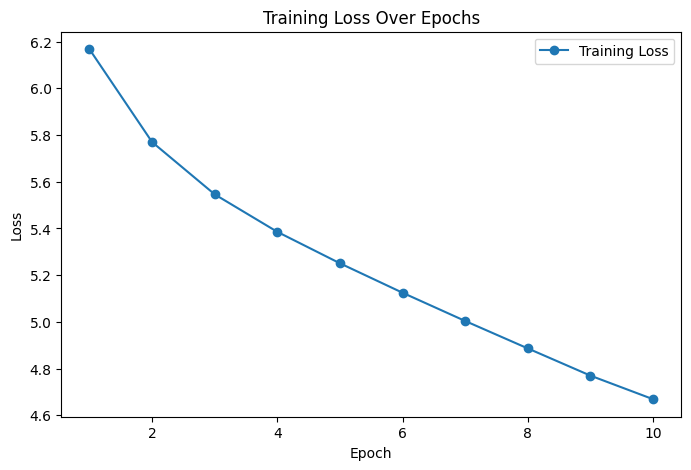

In [52]:
# Create folder if it doesn't exist
model_save_path = "../saved_models/lstm/"
os.makedirs(model_save_path, exist_ok=True)

# Convert your preprocessed sequences (train_articles_seq & train_summaries_seq) to torch tensors.
train_articles_tensor = torch.tensor(train_articles_seq, dtype=torch.long)
train_summaries_tensor = torch.tensor(train_summaries_seq, dtype=torch.long)

# Create a Dataset and DataLoader.
train_dataset_lstm = TensorDataset(train_articles_tensor, train_summaries_tensor)
batch_size = 32   # you can adjust batch size as needed
train_loader = DataLoader(train_dataset_lstm, batch_size=batch_size, shuffle=True)

# Define loss function and optimizer.
# Note: We ignore the PAD tokens (using vocab[PAD_TOKEN]) when computing loss.
criterion = nn.CrossEntropyLoss(ignore_index=vocab[PAD_TOKEN])
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

# Set number of training epochs and teacher forcing ratio.
num_epochs = 10
teacher_forcing_ratio = 0.5   # chance to use teacher forcing at each time step

training_losses = []
best_loss = float("inf")

# Training loop for the Encoder-Decoder with attention.
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    epoch_loss = 0
    num_batches = len(train_loader)
    
    for src_batch, trg_batch in train_loader:
        src_batch, trg_batch = src_batch.to(device), trg_batch.to(device)  # [batch_size, seq_len]
        optimizer.zero_grad()
        
        # Run the encoder
        enc_outputs, hidden, cell = encoder(src_batch)
        batch_size_current = src_batch.size(0)
        trg_seq_len = trg_batch.size(1)
        
        # Prepare a placeholder for storing all decoder outputs.
        outputs_all = torch.zeros(batch_size_current, trg_seq_len, vocab_size).to(device)
        
        # Set the first input to the decoder with SOS token (already added at index 0 in each summary).
        dec_input = trg_batch[:, 0]  # shape: [batch_size]
        
        # For each time step in the target sequence (skipping index 0)
        for t in range(1, trg_seq_len):
            # Forward pass through the decoder.
            output, hidden, cell, attn_weights = decoder(dec_input, hidden, cell, enc_outputs)
            # Store current time-step predictions.
            outputs_all[:, t, :] = output
            
            # Decide whether to use teacher forcing.
            teacher_force = np.random.random() < teacher_forcing_ratio
            # The token to feed at next time step: the true token (teacher forcing) or the predicted token.
            top1 = output.argmax(1)  # [batch_size]
            dec_input = trg_batch[:, t] if teacher_force else top1
        
        # Compute loss. We skip the first token (index 0) since that’s our initial SOS token.
        loss = criterion(outputs_all[:, 1:, :].reshape(-1, vocab_size),
                          trg_batch[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / num_batches
    training_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")
    
    # Save the model if this epoch produced a new best loss.
    if avg_loss < best_loss:
        best_loss = avg_loss
        checkpoint = {
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }
        torch.save(checkpoint, os.path.join(model_save_path, "best_model.pth"))
        print(f"Best model saved with loss {best_loss:.4f}")

# Plot the training loss curve.
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), training_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

#### T5-Base Tuning with Lora

In [47]:
# -------------------------
# Apply LoRA to T5-small model
# -------------------------
print("\n*** Applying LoRA to T5-small ***")
lora_config_t5 = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=16,                      # Lower rank to reduce parameter count
    lora_alpha=16,            # Scaling factor for LoRA weights
    lora_dropout=0.1,         # Dropout probability for robustness
    target_modules=["q", "v"] # Targeting query and value projection layers
)
model_t5 = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
# Wrap the model with LoRA adapters.
model_t5 = get_peft_model(model_t5, lora_config_t5)
model_t5.to(device)
# Optionally print trainable parameter info.
model_t5.print_trainable_parameters()


*** Applying LoRA to T5-small ***
trainable params: 589,824 || all params: 61,096,448 || trainable%: 0.9654


In [49]:
# For T5-small with LoRA:
model_save_dir_t5 = "../saved_models/t5-small-lora/"
os.makedirs(model_save_dir_t5, exist_ok=True)

training_args_t5 = TrainingArguments(
    output_dir=model_save_dir_t5,
    num_train_epochs=10,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=500,
    logging_strategy="epoch",
    bf16=True if torch.backends.mps.is_available() else False,
)

trainer_t5 = Trainer(
    model=model_t5,
    args=training_args_t5,
    train_dataset=t5_tokenized_datasets["train"],
    eval_dataset=t5_tokenized_datasets["validation"],
    tokenizer=tokenizer_t5,
)

print("Starting LoRA training for T5-small...")
train_result_t5 = trainer_t5.train()
save_path_t5 = os.path.join(model_save_dir_t5, "best_model")
trainer_t5.save_model(save_path_t5)
print("T5-small with LoRA best model saved at:", save_path_t5)

/var/folders/m7/0mpffhzd33gczk0zczkvl6p40000gn/T/ipykernel_68515/1068786084.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_t5 = Trainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting LoRA training for T5-small...


Step,Training Loss
14355,2.086300
28710,2.054100
43065,2.046800
57420,2.040800
71775,2.035300
86130,2.033800
100485,2.030900
114840,2.028500
129195,2.027300
143550,2.024800


/Users/bikinghimire/.pyenv/versions/3.11.8/envs/ats-env/lib/python3.11/site-packages/peft/utils/other.py:1107: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 1c07cbd6-1f3b-4c02-9efa-1648d580c343)') - silently ignoring the lookup for the file config.json in t5-small.
  warnings.warn(
/Users/bikinghimire/.pyenv/versions/3.11.8/envs/ats-env/lib/python3.11/site-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in t5-small - will assume that the vocabulary was not modified.
  warnings.warn(
/Users/bikinghimire/.pyenv/versions/3.11.8/envs/ats-env/lib/python3.11/site-packages/peft/utils/other.py:1107: UserWarning: Unable to fetch remote file due to the following error (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /t5-small/resolve/main/config.json (Caused by Na

T5-small with LoRA best model saved at: ../saved_models/t5-small-lora/best_model


#### Bart-large-cnn Tuning with LoRA

In [19]:
# -------------------------
# Apply LoRA to BART-large-cnn model
# -------------------------
print("\n*** Applying LoRA to BART-large-cnn ***")
lora_config_bart = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=16,                         # Using a low rank for efficiency
    lora_alpha=16,                # Scaling factor for LoRA weights
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"]  # Targeting attention projection layers
)
model_bart = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")
# Wrap the model with LoRA adapters.
model_bart = get_peft_model(model_bart, lora_config_bart)
model_bart.to(device)
model_bart.print_trainable_parameters()


*** Applying LoRA to BART-large-cnn ***
trainable params: 2,359,296 || all params: 408,649,728 || trainable%: 0.5773


In [20]:
# For BART-large-cnn with LoRA:
model_save_dir_bart = "../saved_models/bart-large-cnn-lora/"
os.makedirs(model_save_dir_bart, exist_ok=True)

training_args_bart = TrainingArguments(
    output_dir=model_save_dir_bart,
    num_train_epochs=3,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50000,
    logging_strategy="epoch",
    bf16=True if torch.backends.mps.is_available() else False,
)

trainer_bart = Trainer(
    model=model_bart,
    args=training_args_bart,
    train_dataset=bart_tokenized_datasets["train"],
    eval_dataset=bart_tokenized_datasets["validation"],
    tokenizer=tokenizer_bart,
)

print("Starting LoRA training for BART-large-cnn...")
train_result_bart = trainer_bart.train()
save_path_bart = os.path.join(model_save_dir_bart, "best_model")
trainer_bart.save_model(save_path_bart)
print("BART-large-cnn with LoRA best model saved at:", save_path_bart)

/var/folders/m7/0mpffhzd33gczk0zczkvl6p40000gn/T/ipykernel_46889/1361567102.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bart = Trainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting LoRA training for BART-large-cnn...


Step,Training Loss
14355,1.631200
28710,1.342200
43065,1.317800


BART-large-cnn with LoRA best model saved at: ../saved_models/bart-large-cnn-lora/best_model
